In [1]:
import numpy as np
np.random.seed(123)
from tensorflow.keras.models import Sequential
#sequential is a stack of nerual network layers
import tensorflow as tf
tf.random.set_seed(123)

from tensorflow.keras.layers import Dense, Activation
#dense is a ully connected network, activation is a non linear function applied to the network.

from keras.utils import np_utils
import matplotlib.pyplot as plt

from keras.datasets import mnist
(X_train1, y_train1), (X_test1, y_test1) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step


In [0]:
def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    #combinedReal = np.real(combined)
    #combinedImag = np.imag(combined)
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined


In [0]:
def pre_process_shuffle(dataset):
  mag = np.zeros(dataset.shape)
  phase = np.zeros(dataset.shape)
  shuffle = np.zeros(dataset.shape)
  phase_shuffle = np.zeros(dataset.shape)
  x= 0
  for i in range(0,dataset.shape[0]):
    mag[i,:,:],phase[i,:,:] = compute_mag_phase(dataset[i])
  ind = np.arange(phase.shape[0])
  np.random.shuffle(ind)
  phase_shuffle  = phase[ind,: , :]
  for i in range(0,dataset.shape[0]):
    shuffle[i,:,:] = reconstruct(mag[i],phase_shuffle[i])
  return shuffle

In [0]:
X_train_shuff= pre_process_shuffle(X_train1)
X_test_shuff = pre_process_shuffle(X_test1)

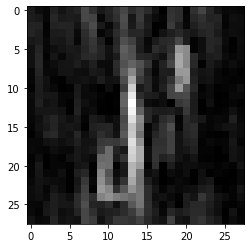

In [0]:
plt.subplot(111)
plt.imshow(X_train_shuff[8], cmap='gray')

In [0]:
X_train_flatten = X_train_shuff.reshape(X_train_shuff.shape[0], X_train_shuff.shape[1] * X_train_shuff.shape[2])
X_test_flatten = X_test_shuff.reshape(X_test_shuff.shape[0], X_test_shuff.shape[1] * X_test_shuff.shape[2])

X_train_flatten = X_train_flatten.astype('float32')
X_test_flatten = X_test_flatten.astype('float32')
X_train_flatten /= 255
X_test_flatten /= 255
Y_train_class = np_utils.to_categorical(y_train1, 10)
Y_test_class = np_utils.to_categorical(y_test1, 10)

In [0]:
model = Sequential([
    Dense(10, input_shape=(784,)),
    Activation('softmax'),
])

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                7850      
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
history = model.fit(X_train_flatten, Y_train_class, batch_size=32, epochs=100)

Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.1633 - accuracy: 0.2207
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 2.0828 - accuracy: 0.2628
Epoch 3/100
 228/1875 [==>...........................] - ETA: 3s - loss: 2.0505 - accuracy: 0.2762

KeyboardInterrupt: ignored


very low accuracy when phase is shuffled, only about a third correct so far (no hidden layers though)

In [0]:
from keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.utils.np_utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Helper: Early stopping.
early_stopper = EarlyStopping(patience=5)

def get_mnist():
    """Retrieve the MNIST dataset and process the data."""
    # Set defaults.
    nb_classes = 10
    batch_size = 128
    input_shape = (784,)

    # Get the data.
    x_train = X_train_flatten
    x_test = X_test_flatten

    # convert class vectors to binary class matrices
    y_train = to_categorical(y_train1, nb_classes)
    y_test = to_categorical(y_test1, nb_classes)
    print('done mnist')
    return (nb_classes, batch_size, input_shape, x_train, x_test, y_train, y_test)

def compile_model(network, nb_classes, input_shape):
    """Compile a sequential model.
    Args:
        network (dict): the parameters of the network
    Returns:
        a compiled network.
    """
    # Get our network parameters.
    nb_layers = network['nb_layers']
    nb_neurons1 = network['nb_neurons1']
    nb_neurons2 = network['nb_neurons2']
    nb_neurons3 = network['nb_neurons3']
    nb_neurons4 = network['nb_neurons4']
    activation = network['activation']
    optimizer = network['optimizer']

    model = Sequential()

    # Add each layer.
    for i in range(nb_layers):

        # Need input shape for first layer.
        if i == 0:
            model.add(Dense(nb_neurons1, activation=activation, input_shape=input_shape))
        elif i == 1:
            model.add(Dense(nb_neurons2, activation=activation))
        elif i == 2:
            model.add(Dense(nb_neurons3, activation=activation))
        elif i == 3:
            model.add(Dense(nb_neurons4, activation=activation))

        model.add(Dropout(0.2))  # hard-coded dropout

    # Output layer.
    model.add(Dense(nb_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer,
                  metrics=['accuracy'])
    print('compiled model')
    return model

def train_and_score(network, dataset):
    """Train the model, return test loss.
    Args:
        network (dict): the parameters of the network
        dataset (str): Dataset to use for training/evaluating
    """
    logging.info("***train_and_score***")
    if dataset == 'cifar10':
        nb_classes, batch_size, input_shape, x_train, \
            x_test, y_train, y_test = get_cifar10()
    elif dataset == 'mnist':
        logging.info("***mnist***")
        nb_classes, batch_size, input_shape, x_train, \
            x_test, y_train, y_test = get_mnist()

    model = compile_model(network, nb_classes, input_shape)
    logging.info("***compiled_model***")
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=100,  # using early stopping, so no real limit
              verbose=0,
              validation_split=0.2,
              callbacks=[early_stopper])
    #validation_split=0.2, epochs=100, batch_size=2000,
    #validation_data=(x_test, y_test),
    score = model.evaluate(x_test, y_test, verbose=0)
    logging.info("***trainedd***")
    print(score[1])
    return score[1]  # 1 is accuracy. 0 is loss.

In [0]:
import random
import logging
#from train import train_and_score

class Network():
    """Represent a network and let us operate on it.
    Currently only works for an MLP.
    """

    def __init__(self, nn_param_choices=None):
        """Initialize our network.
        Args:
            nn_param_choices (dict): Parameters for the network, includes:
                nb_neurons (list): [64, 128, 256]
                nb_layers (list): [1, 2, 3, 4]
                activation (list): ['relu', 'elu']
                optimizer (list): ['rmsprop', 'adam']
        """
        self.accuracy = 0.
        self.nn_param_choices = nn_param_choices
        self.network = {}  # (dic): represents MLP network parameters

    def create_random(self):
        i = True 
        """Create a random network."""
        for key in self.nn_param_choices:
            if key == 'nb_neurons2':
              while (True):
                logging.info("stuck 1")
                self.network[key] = random.choice(self.nn_param_choices[key])
                if self.network[key] < self.network['nb_neurons1']:
                  break
            elif key == 'nb_neurons3':
              while (True):
                logging.info("stuck 2")
                self.network[key] = random.choice(self.nn_param_choices[key])
                if self.network[key] < self.network['nb_neurons2']:
                  break
            elif key == 'nb_neurons4':
              while (True):
                logging.info("stuck 3")
                self.network[key] = random.choice(self.nn_param_choices[key])
                if self.network[key] < self.network['nb_neurons3']:
                  break
            else:
              self.network[key] = random.choice(self.nn_param_choices[key])



    def create_set(self, network):
        """Set network properties.
        Args:
            network (dict): The network parameters
        """
        self.network = network

    def train(self, dataset):
        """Train the network and record the accuracy.
        Args:
            dataset (str): Name of dataset to use.
        """
        logging.info("***train***")
        if self.accuracy == 0.:
            self.accuracy = train_and_score(self.network, dataset)

    def print_network(self):
        """Print out a network."""
        logging.info(self.network)
        logging.info("Network accuracy: %.2f%%" % (self.accuracy * 100))

In [0]:
from functools import reduce
from operator import add
import random


class Optimizer():
    """Class that implements genetic algorithm for MLP optimization."""

    def __init__(self, nn_param_choices, retain=0.4,
                 random_select=0.1, mutate_chance=0.3):
        """Create an optimizer.
        Args:
            nn_param_choices (dict): Possible network paremters
            retain (float): Percentage of population to retain after
                each generation
            random_select (float): Probability of a rejected network
                remaining in the population
            mutate_chance (float): Probability a network will be
                randomly mutated
        """
        self.mutate_chance = mutate_chance
        self.random_select = random_select
        self.retain = retain
        self.nn_param_choices = nn_param_choices

    def create_population(self, count):
        """Create a population of random networks.
        Args:
            count (int): Number of networks to generate, aka the
                size of the population
        Returns:
            (list): Population of network objects
        """
        pop = []
        for _ in range(0, count):
            # Create a random network.
            network = Network(self.nn_param_choices)
            logging.info("count")
            network.create_random()

            # Add the network to our population.
            pop.append(network)

        return pop

    @staticmethod
    def fitness(network):
        """Return the accuracy, which is our fitness function."""
        return network.accuracy

    def grade(self, pop):
        """Find average fitness for a population.
        Args:
            pop (list): The population of networks
        Returns:
            (float): The average accuracy of the population
        """
        summed = reduce(add, (self.fitness(network) for network in pop))
        return summed / float((len(pop)))

    def breed(self, mother, father):
        """Make two children as parts of their parents.
        Args:
            mother (dict): Network parameters
            father (dict): Network parameters
        Returns:
            (list): Two network objects
        """
        children = []
        for _ in range(2):

            child = {}

            #  need to do if they have equal layers
            # Loop through the parameters and pick params for the kid.
            for param in self.nn_param_choices:
                  if (param == 'nb_neurons2') :
                    while (True):
                        child[param] = random.choice([mother.network[param], father.network[param]])
                        if child[param] < child['nb_neurons1']:
                            logging.info("***broke1***")
                            break
                  elif param == 'nb_neurons3':
                    while ( True):
                        child[param] = random.choice([mother.network[param], father.network[param]])
                        if child[param] < child['nb_neurons2']:
                            break
                            logging.info("***broke2***")
                  elif param == 'nb_neurons4':
                    while (True):
                        child[param] = random.choice([mother.network[param], father.network[param]])
                        if child[param] < child['nb_neurons3']:
                            break
                            logging.info("***broke3***")
                  else:
                    child[param] = random.choice([mother.network[param], father.network[param]])

            # Now create a network object.
            network = Network(self.nn_param_choices)
            network.create_set(child)

            # Randomly mutate some of the children.
            if self.mutate_chance > random.random():
                network = self.mutate(network)

            children.append(network)

        return children

    def mutate(self, network):
        """Randomly mutate one part of the network.
        Args:
            network (dict): The network parameters to mutate
        Returns:
            (Network): A randomly mutated network object
        """
        # Choose a random key.

 
        mutation = random.choice(list(self.nn_param_choices.keys()))
        
        #mutate param within condition
        if mutation == 'nb_neurons1':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] > network.network['nb_neurons2']):
                    break
        elif mutation == 'nb_neurons2':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] > network.network['nb_neurons3']) and (network.network[mutation] < network.network['nb_neurons1']) :
                    break
        elif mutation == 'nb_neurons3':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] > network.network['nb_neurons4'])  and (network.network[mutation] < network.network['nb_neurons2']):
                    break
        elif mutation == 'nb_neurons4':
            while (True):
                  network.network[mutation] = random.choice(self.nn_param_choices[mutation])
                  if (network.network[mutation] < network.network['nb_neurons3']):
                    break
        else:
          # Mutate one of the params.
          network.network[mutation] = random.choice(self.nn_param_choices[mutation])
        return network

    def evolve(self, pop):
        """Evolve a population of networks.
        Args:
            pop (list): A list of network parameters
        Returns:
            (list): The evolved population of networks
        """
        # Get scores for each network.
        graded = [(self.fitness(network), network) for network in pop]

        # Sort on the scores.
        graded = [x[1] for x in sorted(graded, key=lambda x: x[0], reverse=True)]

        # Get the number we want to keep for the next gen.
        retain_length = int(len(graded)*self.retain)

        # The parents are every network we want to keep.
        parents = graded[:retain_length]

        # For those we aren't keeping, randomly keep some anyway.
        for individual in graded[retain_length:]:
            if self.random_select > random.random():
                parents.append(individual)

        # Now find out how many spots we have left to fill.
        parents_length = len(parents)
        desired_length = len(pop) - parents_length
        children = []

        # Add children, which are bred from two remaining networks.
        while len(children) < desired_length:

            # Get a random mom and dad.
            print(parents_length-1)
            male = random.randint(0, parents_length-1)

            female = random.randint(0, parents_length-1)

            # Assuming they aren't the same network...
            if male != female:
                male = parents[male]
                female = parents[female]

                # Breed them.
                babies = self.breed(male, female)

                # Add the children one at a time.
                for baby in babies:
                    # Don't grow larger than desired length.
                    if len(children) < desired_length:
                        children.append(baby)

        parents.extend(children)

        return parents

In [0]:
import logging
from tqdm import tqdm

# Setup logging.
logging.basicConfig(
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.DEBUG,
    filename='log.txt'
)

def train_networks(networks, dataset):
    """Train each network.
    Args:
        networks (list): Current population of networks
        dataset (str): Dataset to use for training/evaluating
    """

    pbar = tqdm(total=len(networks))
    logging.info("***a***")
    for network in networks:
        network.train(dataset)
        pbar.update(1)
        logging.info("***b***")
    pbar.close()

def get_average_accuracy(networks):
    """Get the average accuracy for a group of networks.
    Args:
        networks (list): List of networks
    Returns:
        float: The average accuracy of a population of networks.
    """
    total_accuracy = 0
    for network in networks:
        total_accuracy += network.accuracy

    return total_accuracy / len(networks)

def generate(generations, population, nn_param_choices, dataset):
    """Generate a network with the genetic algorithm.
    Args:
        generations (int): Number of times to evole the population
        population (int): Number of networks in each generation
        nn_param_choices (dict): Parameter choices for networks
        dataset (str): Dataset to use for training/evaluating
    """
    optimizer = Optimizer(nn_param_choices)
    logging.info("***Optimizer***")
    networks = optimizer.create_population(population)

    # Evolve the generation.
    for i in range(generations):
        logging.info("***Doing generation %d of %d***" %
                     (i + 1, generations))

        # Train and get accuracy for networks.
        train_networks(networks, dataset)
        logging.info("***Trained networks***")
        # Get the average accuracy for this generation.
        average_accuracy = get_average_accuracy(networks)

        # Print out the average accuracy each generation.
        logging.info("Generation average: %.2f%%" % (average_accuracy * 100))
        logging.info('-'*80)

        # Evolve, except on the last iteration.
        if i != generations - 1:
            # Do the evolution.
            networks = optimizer.evolve(networks)

    # Sort our final population.
    networks = sorted(networks, key=lambda x: x.accuracy, reverse=True)

    # Print out the top 5 networks.
    print_networks(networks[:5])

def print_networks(networks):
    """Print a list of networks.
    Args:
        networks (list): The population of networks
    """
    logging.info('-'*80)
    for network in networks:
        network.print_network()

def main():
    """Evolve a network."""
    generations = 7  # Number of times to evole the population.
    population = 20  # Number of networks in each generation.
    dataset = 'mnist'
    print(2)

    nn_param_choices = {
        #'nb_neurons': [10, 60, 110, 160, 210, 260,310,360,410,460,510],
        'nb_neurons1': range(14,780),
        'nb_neurons2':  range(13,779),
        'nb_neurons3': range(12,778),
        'nb_neurons4': range(11,777),
        'nb_layers': [1, 2, 3, 4],
        'activation': ['relu', 'elu', 'tanh', 'sigmoid'],
        'optimizer': ['rmsprop', 'adam', 'sgd', 'adagrad',
                      'adadelta', 'adamax', 'nadam'],
    }
    print(3)
    logging.info("***Evolving %d generations with population %d***" %
                 (generations, population))
    print(4)
    generate(generations, population, nn_param_choices, dataset)
    print('done')

if __name__ == '__main__':
    main()

  0%|          | 0/20 [00:00<?, ?it/s]

2
3
4
done mnist
compiled model


  5%|▌         | 1/20 [00:21<06:48, 21.49s/it]

0.2709999978542328
done mnist
compiled model


 10%|█         | 2/20 [01:10<08:57, 29.88s/it]

0.5551000237464905
done mnist
compiled model


 15%|█▌        | 3/20 [02:27<12:24, 43.77s/it]

0.46160000562667847
done mnist
compiled model


 20%|██        | 4/20 [02:56<10:32, 39.53s/it]

0.5716000199317932
done mnist
compiled model


 25%|██▌       | 5/20 [03:51<11:00, 44.05s/it]

0.4325999915599823
done mnist
compiled model


 30%|███       | 6/20 [04:44<10:53, 46.69s/it]

0.4966999888420105
done mnist
compiled model


 35%|███▌      | 7/20 [06:00<12:02, 55.55s/it]

0.2476000040769577
done mnist
compiled model


 40%|████      | 8/20 [06:22<09:06, 45.52s/it]

0.520799994468689
done mnist
compiled model


 45%|████▌     | 9/20 [06:47<07:11, 39.23s/it]

0.5785999894142151
done mnist
compiled model


 50%|█████     | 10/20 [08:05<08:28, 50.87s/it]

0.3752000033855438
done mnist
compiled model


 55%|█████▌    | 11/20 [08:29<06:26, 42.91s/it]

0.5408999919891357
done mnist
compiled model


 60%|██████    | 12/20 [09:53<07:22, 55.29s/it]

0.4424000084400177
done mnist
compiled model


 65%|██████▌   | 13/20 [10:12<05:10, 44.31s/it]

0.5730000138282776
done mnist
compiled model


 70%|███████   | 14/20 [11:24<05:15, 52.58s/it]

0.414900004863739
done mnist
compiled model


 75%|███████▌  | 15/20 [12:13<04:18, 51.70s/it]

0.5906000137329102
done mnist
compiled model


 80%|████████  | 16/20 [12:37<02:53, 43.33s/it]

0.5870000123977661
done mnist
compiled model


 85%|████████▌ | 17/20 [13:56<02:42, 54.13s/it]

0.5799999833106995
done mnist
compiled model


 90%|█████████ | 18/20 [14:37<01:40, 50.07s/it]

0.5727999806404114
done mnist
compiled model


 95%|█████████▌| 19/20 [14:56<00:40, 40.62s/it]

0.5728999972343445
done mnist
compiled model


  0%|          | 0/20 [00:00<?, ?it/s]

0.2766000032424927
9
9
9
9
9
done mnist
compiled model


 55%|█████▌    | 11/20 [01:20<01:05,  7.28s/it]

0.5828999876976013
done mnist
compiled model


 60%|██████    | 12/20 [01:38<01:24, 10.50s/it]

0.5920000076293945
done mnist
compiled model


 65%|██████▌   | 13/20 [02:13<02:05, 17.87s/it]

0.570900022983551
done mnist
compiled model


 70%|███████   | 14/20 [02:48<02:18, 23.07s/it]

0.5676000118255615
done mnist
compiled model


 75%|███████▌  | 15/20 [03:28<02:20, 28.08s/it]

0.57669997215271
done mnist
compiled model


 80%|████████  | 16/20 [04:08<02:06, 31.63s/it]

0.5770999789237976
done mnist
compiled model


 85%|████████▌ | 17/20 [04:24<01:21, 27.08s/it]

0.5713000297546387
done mnist
compiled model


 90%|█████████ | 18/20 [04:47<00:51, 25.83s/it]

0.5713000297546387
done mnist
compiled model


 95%|█████████▌| 19/20 [05:17<00:27, 27.13s/it]

0.5738999843597412
done mnist
compiled model


  0%|          | 0/20 [00:00<?, ?it/s]

0.583899974822998
7
7
7
7
7
7
done mnist
compiled model


 45%|████▌     | 9/20 [00:45<00:56,  5.09s/it]

0.5623999834060669
done mnist
compiled model


 50%|█████     | 10/20 [01:12<01:54, 11.44s/it]

0.5906999707221985
done mnist
compiled model


 55%|█████▌    | 11/20 [01:34<02:11, 14.61s/it]

0.5723000168800354
done mnist
compiled model


 60%|██████    | 12/20 [02:01<02:28, 18.59s/it]

0.5885000228881836
done mnist
compiled model


 65%|██████▌   | 13/20 [02:32<02:35, 22.19s/it]

0.5906000137329102
done mnist
compiled model


 70%|███████   | 14/20 [03:06<02:34, 25.73s/it]

0.5914999842643738
done mnist
compiled model


 75%|███████▌  | 15/20 [03:30<02:06, 25.34s/it]

0.5813999772071838
done mnist
compiled model


 80%|████████  | 16/20 [04:13<02:01, 30.46s/it]

0.5794000029563904
done mnist
compiled model


 85%|████████▌ | 17/20 [05:32<02:15, 45.20s/it]

0.5794000029563904
done mnist
compiled model


 90%|█████████ | 18/20 [06:13<01:27, 43.87s/it]

0.578499972820282
done mnist
compiled model


 95%|█████████▌| 19/20 [06:39<00:38, 38.46s/it]

0.5755000114440918
done mnist
compiled model


  0%|          | 0/20 [00:00<?, ?it/s]

0.5770000219345093
8
8
8
8
8
8
8
8
done mnist
compiled model


 50%|█████     | 10/20 [00:21<00:21,  2.18s/it]

0.5759999752044678
done mnist
compiled model


 55%|█████▌    | 11/20 [01:12<02:30, 16.77s/it]

0.5903000235557556
done mnist
compiled model


 60%|██████    | 12/20 [01:43<02:48, 21.07s/it]

0.567300021648407
done mnist
compiled model


 65%|██████▌   | 13/20 [02:10<02:38, 22.68s/it]

0.5884000062942505
done mnist
compiled model


 70%|███████   | 14/20 [02:35<02:20, 23.47s/it]

0.5353000164031982
done mnist
compiled model


 75%|███████▌  | 15/20 [03:11<02:15, 27.10s/it]

0.5860000252723694
done mnist
compiled model


 80%|████████  | 16/20 [03:46<01:58, 29.63s/it]

0.5848000049591064
done mnist
compiled model


 85%|████████▌ | 17/20 [04:33<01:44, 34.93s/it]

0.54339998960495
done mnist
compiled model


 90%|█████████ | 18/20 [04:52<00:59, 29.94s/it]

0.5796999931335449
done mnist
compiled model


 95%|█████████▌| 19/20 [05:36<00:34, 34.38s/it]

0.5986999869346619
done mnist
compiled model


  0%|          | 0/20 [00:00<?, ?it/s]

0.5867000222206116
9
9
9
9
9
9
9
9
done mnist
compiled model


 55%|█████▌    | 11/20 [00:33<00:27,  3.04s/it]

0.5950000286102295
done mnist
compiled model


 60%|██████    | 12/20 [01:06<01:37, 12.19s/it]

0.597000002861023
done mnist
compiled model


 65%|██████▌   | 13/20 [01:36<02:01, 17.38s/it]

0.5720000267028809
done mnist
compiled model


 70%|███████   | 14/20 [02:27<02:44, 27.43s/it]

0.6000000238418579
done mnist
compiled model


Around 60% - p good considering.